<a href="https://colab.research.google.com/github/fraboeni/fraboeni.github.io/blob/master/files/2020-12-22-blog-post-00/model_inversion_attack_with_IBM_ART.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
!pip install adversarial-robustness-toolbox

In [6]:
from art.attacks.inference import model_inversion 
from art.estimators.classification import KerasClassifier

In [7]:
def load_mnist():
  """Loads MNIST-Dataset and preprocesses to combine training and test data."""
  
  # load the existing MNIST digit dataset that comes in form of traing + test data and labels
  train, test = tf.keras.datasets.mnist.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # convolutional layers expect images to have 3 dimensions (width, height, depth)
  # in color images the depth is 3 for the RGB channels
  # MNIST is grayscale and hence originally does not need a third dimension
  # so we need to artificially add it
  train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
  test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
  return train_data, train_labels, test_data, test_labels
 
def make_model():
  """ Define a Keras model"""
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(16, 8,
                              strides=2,
                              padding='same',
                              activation='relu',
                              input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Conv2D(32, 4,
                              strides=2,
                              padding='valid',
                              activation='relu'),
      tf.keras.layers.MaxPool2D(2, 1),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  return model

In [ ]:
train_data, train_labels, test_data, test_labels = load_mnist()

In [9]:
# make the neural network model with the function specified above. then look at it
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        1040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [10]:
# specify hyperparameters
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Model Inversion Attack

In [11]:
# convert keras model to ART model
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=False)

In [ ]:
# train the model
history = classifier.fit(train_data, train_labels,
           batch_size=264, nb_epochs=10)

In [59]:
# create the attack object
my_attack = model_inversion.MIFace(classifier)

In [60]:
# create an array of the classes to be attacked
y_all = np.arange(10)
y_all

In [ ]:
inferred_images = my_attack.infer(x=None,y=y_all)


In [ ]:
inferred_images.shape

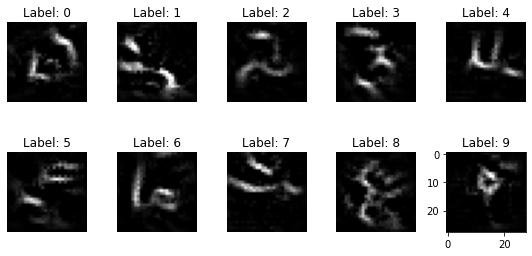

In [64]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax.set_axis_off()
    ax = axes[i//num_col, i%num_col]
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap='gray')
    ax.set_title('Label: {}'.format(y_all[i]))

plt.tight_layout()
plt.show()